In [1]:
%cd ..

/home/jairo/Documentos/GitHub/parallel-kink-scattering


/home/jairo/Documentos/GitHub/parallel-kink-scattering/.env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit
# from string import ascii_lowercase
# from functools import partial
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import periodogram
from matplotlib import colors

from multiprocessing import Pool, Value
from os import cpu_count

from modules.numeric import *

In [18]:
L = 100
N = 2048
DX = 2*L/(N - 1)
DT = 4e-2
X0 = 10

phi4 = Phi4()

def y0(x, A0, sigma):
    return np.stack((
        1 + A0*np.exp(-x**2/sigma),
        np.full(x.shape, 0)
    ))

collider = Wave(
    x_grid= (-L, L, N), 
    dt= DT, 
    order= 4,
    y0= y0,
    F= phi4.diff,
    boundaries=[Reflective(4)]*2
)

(-25.0, 25.0)

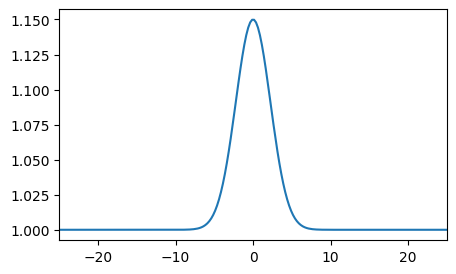

In [21]:
x = np.linspace(-25, 25, 200)
plt.figure(figsize=(5, 3))
plt.plot(x, y0(x, 0.15, 10)[0])
plt.xlim(x.min(), x.max())

In [27]:
def run_and_plot(ax=None, **kwargs):
    lat, Y = collider.run(**kwargs)
    if ax == None: ax = plt.gca()
    im = ax.imshow(Y[:, 0].T, cmap='seismic', extent=lat.extent(), aspect='auto', origin='lower')
    return im

(-50.0, 50.0)

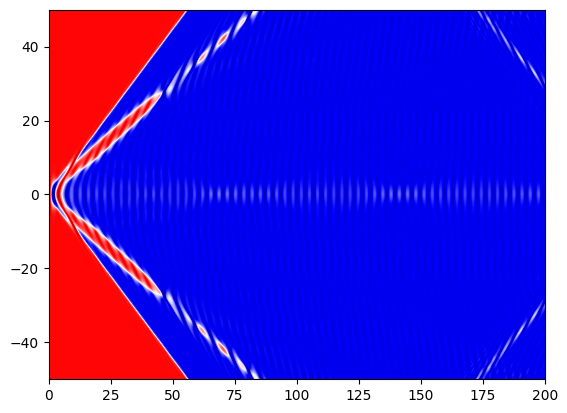

In [120]:
run_and_plot(t_final=200, A0=1, sigma=10)
plt.ylim(-50, 50)

In [73]:
def catch(u, index):
    def _wrapped(t, Y):
        y, _ = Y
        u.append(y[index])
    return _wrapped

def combine(*events):
    def _wrapped(t, Y):
        for event in events:
            event(t, Y)
    return _wrapped

In [111]:
Ns = 200
counter = Value('i', 0)
CM = argnearest(collider.x, 0)
DT = argnearest(collider.x, 20)
f_max = Value('f', 0)
def _task(A0):
    counter.value += 1
    print(f'{(counter.value/Ns*100):.2f}%\r', end='')

    u1 = []
    u2 = []
    collider.run(t_final=200, A0=A0, sigma=10, stack=False, event=combine(catch(u1, CM), catch(u2, DT)))
    f1, Pxx1 = periodogram(u1, 1/DT, nfft=len(u1))
    f2, Pxx2 = periodogram(u2, 1/DT, nfft=len(u2))
    f_max.value = max(f1.max(), f2.max())
    return Pxx1, Pxx2

A0s = np.linspace(0, 1, Ns + 2)[1:-1]
with Pool(int(0.7*cpu_count())) as pool:
    Pxx_map = pool.map(_task, A0s)
Pxx_map = np.stack(Pxx_map)
# freqs, _ = periodogram(np.zeros(Pxx_map.shape[-1]), 1/DT)
df1 = pd.DataFrame(Pxx_map[:, 0])
df2 = pd.DataFrame(Pxx_map[:, 1])

(0.0, 300.0)

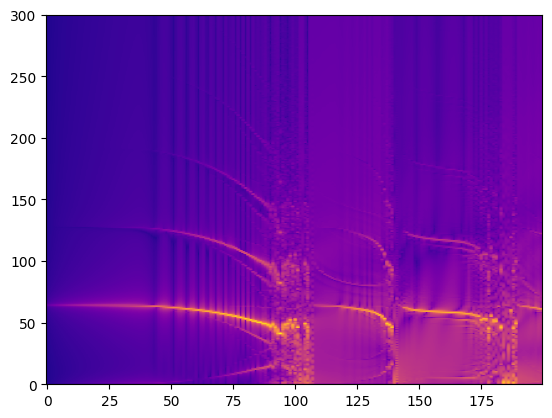

In [115]:
plt.imshow(df1.values.T, aspect='auto', cmap='plasma', origin='lower', norm=colors.PowerNorm(0.15))
plt.ylim(0, 300)

(0.0, 300.0)

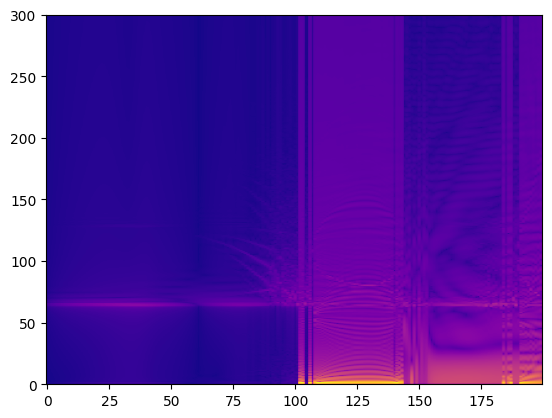

In [118]:
plt.imshow(df2.values.T, aspect='auto', cmap='plasma', origin='lower', norm=colors.PowerNorm(0.15))
plt.ylim(0, 300)